# Brian tumor detection:

### Importing libraries:

In [4]:
import tensorflow as tf
import pandas as pd
import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops

Using TensorFlow backend.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import time
from os import listdir

## preprocessing :

In [6]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

### Loading data:

In [7]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # grey scale
            
            image = crop_brain_contour(image, plot=False)
         
            #resize
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values: Rescale the tensors from values between 0 and 255 to values between 0 and 1,
            #as neural networks prefer to deal with small input values.
            
            #image = image / 255
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [8]:
data_path = 'brain_tumor_dataset/'

# augmented data (yes and no) contains both the original and the new generated examples
data_yes = data_path + 'yes' 
data_no = data_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (200,200)

X, y = load_data([data_yes, data_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 200, 200, 3)
y shape is: (2065, 1)


In [8]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

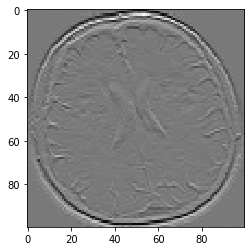

In [24]:
Z = cv2.cvtColor(X[1], cv2.COLOR_BGR2GRAY)
coeffs = pywt.dwt2(Z, 'haar')
cA, (cH, cV, cD) = coeffs
plt.imshow(cH,'gray')

### Discrete wavelet transform :

In [6]:
#importing labray decompostion :
import pywt
## Function discrete wavelet transform :
def DWT( input_img, plot=False):
    Z = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    coeffs = pywt.dwt2(Z, 'haar')
    cA, (cH, cV, cD) = coeffs
    wavelet = [cA, cH, cV, cD]
    if plot :
        titles = ['cA','cH','cV','cD']
        fig, axs = plt.subplots(1,4,figsize=(15,7))
        for i,g in enumerate(wavelet):
            axs[i].imshow(g,'gray')
            axs[i].set_title(titles[i])
        
    return cA, cH, cV, cD;

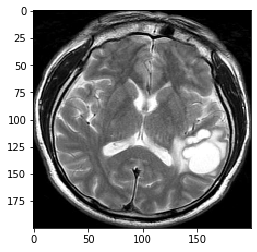

In [20]:
plt.imshow(X[2])

(array([[16. , 16. , 16. , ..., 16. , 16. , 16. ],
        [16. , 16.5, 15.5, ..., 16. , 16. , 16. ],
        [16. , 16.5, 14.5, ..., 16. , 16. , 16. ],
        ...,
        [16. , 16. , 16. , ..., 16. , 16. , 16. ],
        [16. , 16. , 16. , ..., 16. , 16. , 16. ],
        [16. , 16. , 16. , ..., 16. , 16. , 16. ]]),
 array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. , -0.5,  0.5, ...,  0. ,  0. ,  0. ],
        [ 0. ,  0.5,  0.5, ...,  0. ,  0. ,  0. ],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]]),
 array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. , -0.5,  0.5, ...,  0. ,  0. ,  0. ],
        [ 0. ,  0.5,  0.5, ...,  0. ,  0. ,  0. ],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]]),
 array([[ 0. ,  0. ,  0. , ...,  0. ,

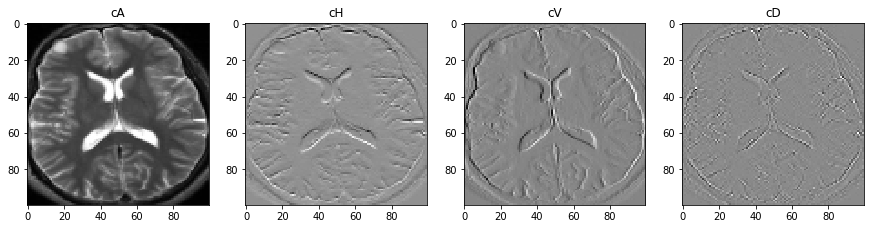

In [7]:
DWT(X[0],True)

In [ ]:
gray = cv2.cvtColor(X[3],cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
## Romoving small white noise
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

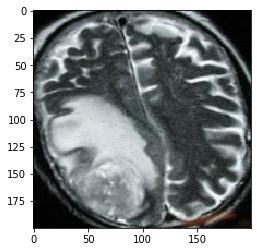

In [32]:
plt.imshow(X[6])

In [ ]:
plt.imshow(sure_bg,'gray')

 ## Image Segmentation with Watershed Algorithm

### Theory:
Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. You start filling every isolated valleys (local minima) with different colored water (labels). As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors will start to merge. To avoid that, you build barriers in the locations where water merges. You continue the work of filling water and building barriers until all the peaks are under water. Then the barriers you created gives you the segmentation result. This is the “philosophy” behind the watershed. 

Now we need to remove any small white noises in the image. For that we can use morphological opening. To remove any small holes in the object, we can use morphological closing. So, now we know for sure that region near to center of objects are foreground and region much away from the object are background. Only region we are not sure is the boundary region of coins.

So we need to extract the area which we are sure they are coins. Erosion removes the boundary pixels. So whatever remaining, we can be sure it is coin. That would work if objects were not touching each other. But since they are touching each other, another good option would be to find the distance transform and apply a proper threshold. Next we need to find the area which we are sure they are not coins. For that, we dilate the result. Dilation increases object boundary to background. This way, we can make sure whatever region in background in result is really a background, since boundary region is removed. See the image below.

In [38]:
def thresholding(img, plot=False, fg=False, bg=False, unknown= False):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    ## Romoving small white noise
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    ## forground part
    if fg:
        dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
        ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
        if plot :
            plt.imshow(sure_fg,'gray')
        return sure_fg
    if bg: 
        sure_bg = cv2.dilate(opening,kernel,iterations=3)
        if plot :
            plt.imshow(sure_bg,'gray')
        return sure_bg
    if unknown: 
        unknown = cv2.dilate(opening,kernel,iterations=3)
        if plot :
            plt.imshow(unknown,'gray')
        return unknown
    else:
        if plot :
            plt.imshow(opening,'gray')
        return opening
    

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

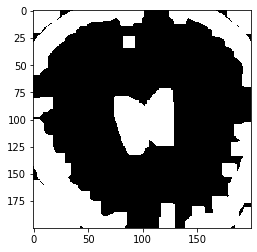

In [44]:
thresholding(X[5],plot=True,unknown=True)

## Textual features:


In [14]:
def textual_features(img):
    Z = img
    Z = cv2.cvtColor(Z, cv2.COLOR_BGR2GRAY)
    glcm = greycomatrix(Z, [10], [0], 256, symmetric=True, normed=True)
    cont = greycoprops(glcm, 'contrast')
    diss = greycoprops(glcm, 'dissimilarity')
    homo = greycoprops(glcm, 'homogeneity')
    eng = greycoprops(glcm, 'energy')
    corr = greycoprops(glcm, 'correlation')
    ASM = greycoprops(glcm, 'ASM')
    return [float(cont[0]), float(diss[0]), float(homo[0]), float(eng[0]), float(corr[0]), float(ASM[0])]


In [15]:
def textual_transform(X,func,y):
    n=len(X)
    new_data = pd.DataFrame(index= range(n) ,columns =['contrast','dissimilarity','homogeneity','energy','correlation','ASM'])
    new_data.fillna(0)
    for i,image in enumerate(X):
        feature = list(func(image))
        new_data.loc[i] = feature
    new_data['Tumor'] = y    
    return new_data    
    

In [16]:
txt_features = textual_transform(X, textual_features,y)

In [31]:
txt_features.head(10)

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,Tumor
0,1276.22,20.2214,0.151709,0.0491221,0.360309,0.00241298,0
1,1478.63,26.5245,0.0928024,0.0241291,0.524693,0.000582211,0
2,5433.8,49.2278,0.126786,0.0886215,0.428665,0.00785378,1
3,3447.76,33.3,0.100485,0.0340934,0.152251,0.00116236,0
4,2667.77,31.0993,0.0742056,0.0191449,0.143745,0.000366528,0
5,2686.94,34.9643,0.0627837,0.0207566,0.354126,0.000430837,0
6,4320.6,46.7769,0.0593369,0.0150028,0.495722,0.000225083,1
7,2553.01,32.3536,0.0787567,0.0319979,0.555889,0.00102387,1
8,1365.44,20.9853,0.117812,0.0318094,0.234249,0.00101184,1
9,2573.66,34.3627,0.0849763,0.0443925,0.419201,0.00197069,1


In [100]:
txt_features.Tumor.value_counts()

1    1085
0     980
Name: Tumor, dtype: int64

### standarization :

In [90]:
def standardize(x):
    centered_data = x - np.mean(x, axis=0)
    std_data = centered_data / np.std(x, axis=0)
    
    return std_data


In [91]:
columns =['contrast','dissimilarity','homogeneity','energy','correlation','ASM']
features = txt_features[columns]
features_scaled = standardize(features)

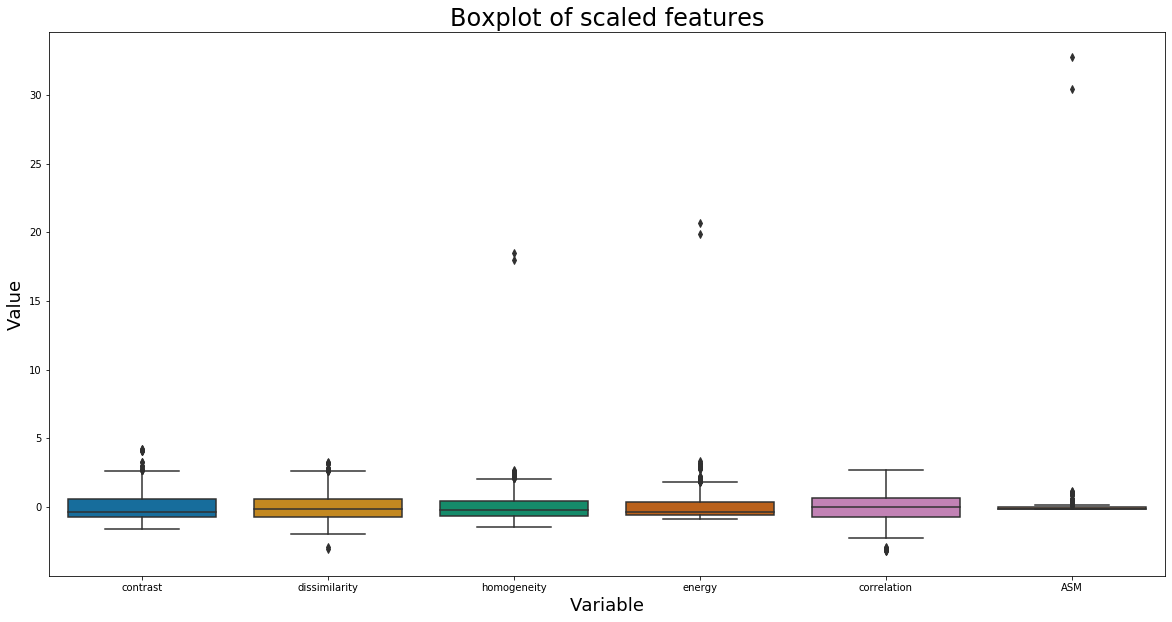

In [92]:
import seaborn as sns

plt.figure(figsize=(20,10))
sns.boxplot(x="variable", y="value", data=pd.melt(features_scaled), palette=sns.color_palette("colorblind"))
plt.xlabel("Variable", fontsize=18)
plt.ylabel("Value", fontsize=18)
plt.title("Boxplot of scaled features", fontsize=24)

plt.show()

### Logistic regression :

In [107]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report
import sklearn as sk
y = txt_features.Tumor
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(features_scaled, y, test_size=0.1,random_state=1)
clf = LogisticRegressionCV(cv=5, random_state=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[70 31]
 [24 82]]
              precision    recall  f1-score   support

           0       0.74      0.69      0.72       101
           1       0.73      0.77      0.75       106

    accuracy                           0.73       207
   macro avg       0.74      0.73      0.73       207
weighted avg       0.73      0.73      0.73       207



### KNN:

In [117]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(X_train, y_train)
knn_pred = classifier.predict(X_test)
print(confusion_matrix(y_test,knn_pred))
print(classification_report(y_test, knn_pred))

[[92  9]
 [12 94]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       101
           1       0.91      0.89      0.90       106

    accuracy                           0.90       207
   macro avg       0.90      0.90      0.90       207
weighted avg       0.90      0.90      0.90       207



### Random Forest :

In [116]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test, rfc_pred))

[[96  5]
 [11 95]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       101
           1       0.95      0.90      0.92       106

    accuracy                           0.92       207
   macro avg       0.92      0.92      0.92       207
weighted avg       0.92      0.92      0.92       207



/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## plotting :

In [10]:
def plot_n_image(X,y,n=10):
    for label in [0,1]:
        images=X[np.argwhere(y==label)]
        n_images=images[:n]
        plt.figure(figsize=(10,10))
        columns_n = 10
        rows_n = int(n/ columns_n)

        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0],'gray')
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()
        

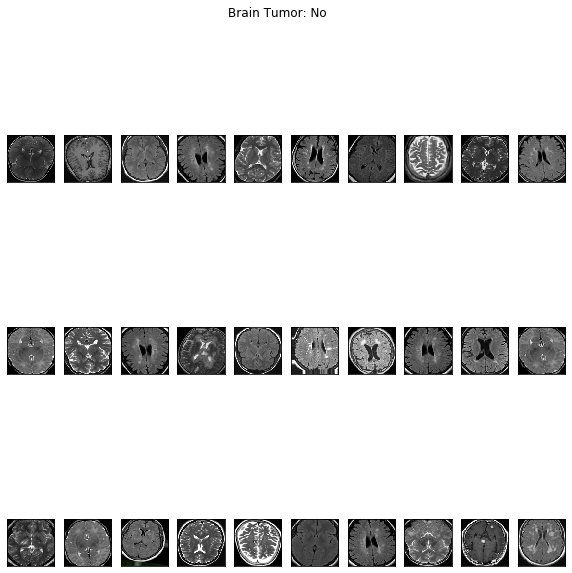

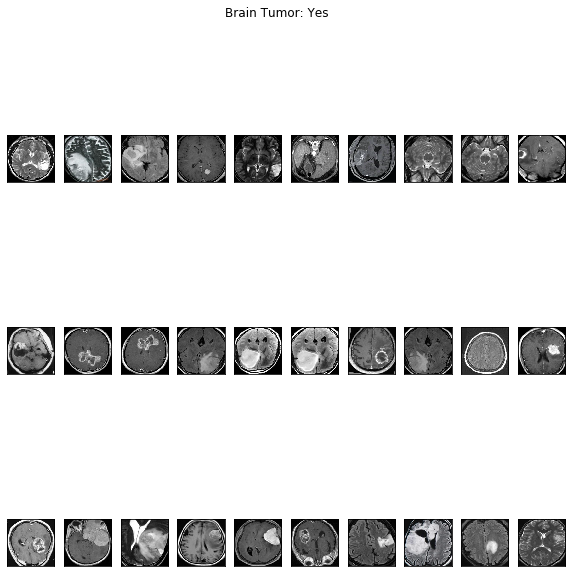

In [12]:
plot_n_image(X,y,30)

### PCA

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
n=len(X)
MRI=pd.DataFrame([])
for i in range(n):
    img = X[i]
    img_pas = pd.Series(img.flatten())
    MRI = MRI.append(img_pas,ignore_index=True)

In [ ]:
MRI.shape

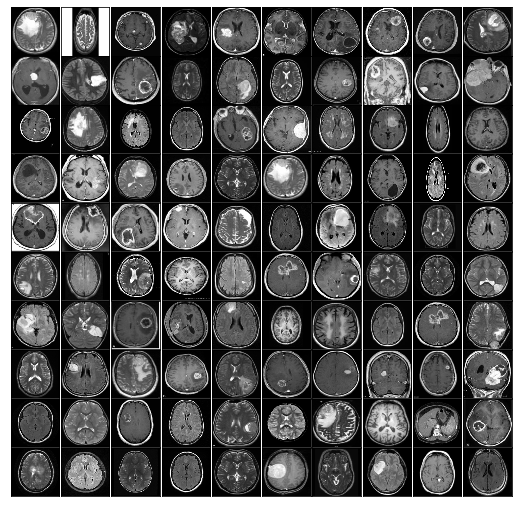

In [13]:
fig, axes = plt.subplots(10,10,figsize=(9,9),
subplot_kw={'xticks':[], 'yticks':[]},
gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(MRI.iloc[i].values.reshape(100,100),cmap='gray')  

In [1]:
from sklearn.decomposition import PCA
MRI_pca = PCA(n_components=0.8)
MRI_pca.fit(MRI)

NameError: name 'MRI' is not defined

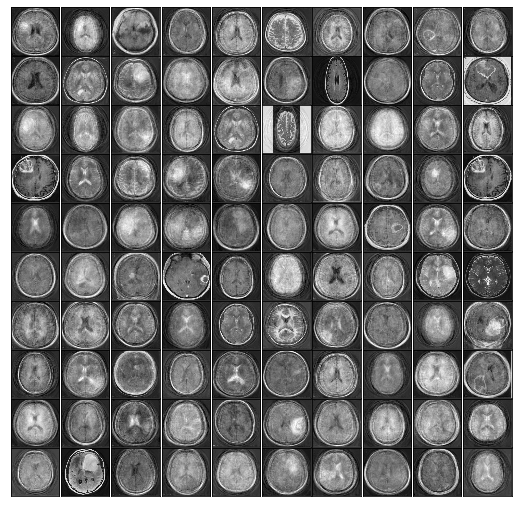

In [155]:
components = MRI_pca.transform(MRI)
projected = MRI_pca.inverse_transform(components)
fig, axes = plt.subplots(10,10,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(projected[i].reshape(100,100),cmap="gray")

In [156]:
projected.shape

(253, 10000)

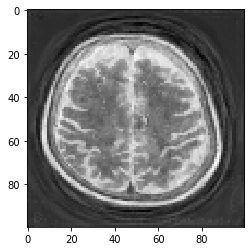

In [167]:
#rearranging the data:
X_pca=[]
n=len(projected)
for i in range(n):
    X_pca.append(projected[i].reshape(100,100))
plt.imshow(X_pca[5], cmap="gray")    

## Training of the CNN :

### splitting the data into training and testing:

In [37]:
batch_size = 128
num_classes = 10
epochs = 10

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [39]:
len(X_train)

1383

In [40]:
img_x=100
img_y=100
X_train = np.reshape(X_train,(len(X_train), img_x, img_y, 1))
X_test = np.reshape(X_test,(len(X_test), img_x, img_y, 1))
input_shape = (img_x, img_y, 1)

In [41]:
X_train.shape

(1383, 100, 100, 1)

### Augmenting the data:

In [42]:
##Augumenting the training data:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
## Augumenting the validation data:
datagen.fit(X_train)


### Building a model :

In [168]:

model = Sequential([
    Conv2D(10, (20,20), activation='relu', input_shape=(100,100,1)),
    Dropout(0.5, noise_shape=None, seed=None),
    MaxPooling2D((4,4)), 
    Conv2D(10, (10,10), activation='relu', input_shape=(23,23,1)),
    Dropout(0.5, noise_shape=None, seed=None),
    MaxPooling2D((2,2)), 
    Flatten(),
    Dense(20, activation='relu',name='dense'),
    Dense(1,activation='sigmoid')
])

In [169]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [170]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 81, 81, 10)        4010      
_________________________________________________________________
dropout_39 (Dropout)         (None, 81, 81, 10)        0         
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 20, 20, 10)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 11, 11, 10)        10010     
_________________________________________________________________
dropout_40 (Dropout)         (None, 11, 11, 10)        0         
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 5, 5, 10)          0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 250)             

In [113]:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=5,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/10
44/44 [==============================] - 21s 486ms/step - loss: 0.6996 - accuracy: 0.4779 - val_loss: 0.6930 - val_accuracy: 0.4575
Epoch 2/10
44/44 [==============================] - 22s 503ms/step - loss: 0.6930 - accuracy: 0.4830 - val_loss: 0.6925 - val_accuracy: 0.4575
Epoch 3/10
44/44 [==============================] - 23s 514ms/step - loss: 0.6934 - accuracy: 0.4830 - val_loss: 0.6925 - val_accuracy: 0.4575
Epoch 4/10
44/44 [==============================] - 23s 527ms/step - loss: 0.6930 - accuracy: 0.4830 - val_loss: 0.6928 - val_accuracy: 0.4575
Epoch 5/10
44/44 [==============================] - 23s 522ms/step - loss: 0.6774 - accuracy: 0.5459 - val_loss: 0.7102 - val_accuracy: 0.5455
Epoch 6/10
44/44 [==============================] - 23s 522ms/step - loss: 0.6617 - accuracy: 0.6088 - val_loss: 0.7413 - val_accuracy: 0.5425
Epoch 7/10
44/44 [==============================] - 24s 544ms/step - loss: 0.6549 - accuracy: 0.6537 - val_loss: 0.7482 - val_accuracy: 0.5425

In [128]:
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[6].output])
X_train_FE = get_3rd_layer_output([X_train])[0]
X_test_FE = get_3rd_layer_output([X_test])[0]
